[How to generate new images?](https://github.com/lucidrains/denoising-diffusion-pytorch/issues/185)

In [29]:
import numpy as np
from PIL import Image
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

In [30]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [31]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
)

In [32]:
diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250,   # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
    loss_type = 'l1'            # L1 or L2
)

In [33]:
state_dict: dict = torch.load("results/forest_200000/model-40.pt")
print(state_dict.keys())
diffusion.load_state_dict(state_dict["model"])
diffusion.to(device)
diffusion.eval()

dict_keys(['step', 'model', 'opt', 'ema', 'scaler', 'version'])


GaussianDiffusion(
  (model): Unet(
    (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            (act):

In [40]:
diffusion.is_ddim_sampling

True

In [34]:
with torch.inference_mode():
    y = diffusion.sample(batch_size=25)
print(y.size())

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([25, 3, 128, 128])


In [35]:
y1 = y.cpu().numpy()

In [36]:
y1 = np.transpose(y1, [0, 2, 3, 1])
y1.shape

(25, 128, 128, 3)

In [37]:
y2 = np.array(y1 * 255, dtype=np.uint8)

In [38]:
def draw_mulit_images_in_one(images: list[np.ndarray], width_repeat: int = 5, line_width: int = 3) -> np.ndarray:
    """将多张图片绘制到一张图片

    Args:
        images (list[np.ndarray]):    绘制的图片列表,所有图片大小相同
        width_repeat (int, optional): x轴重复次数. Defaults to 5.
        line_width (int, optional):   图片之间的线宽. Defaults to 3.

    Returns:
        np.ndarray: 绘制的图片
    """
    import math
    height_repeat = math.ceil(len(images) / width_repeat)

    height, width, channel = images[0].shape
    # new image
    new_height = height * height_repeat + line_width * (height_repeat - 1)
    new_width  = width  * width_repeat  + line_width * (width_repeat  - 1)
    palette = np.zeros((new_height, new_width, channel), dtype=np.uint8)

    for i, image in enumerate(images):
        height_index = math.floor(i / width_repeat) # h index
        width_index  = i % width_repeat             # w index

        # x y 坐标
        height_1 = height_index * (height + line_width)
        height_2 = height_index * (height + line_width) + height
        width_1  = width_index  * (width + line_width)
        width_2  = width_index  * (width + line_width) + width

        palette[height_1:height_2, width_1:width_2] = image

    return palette

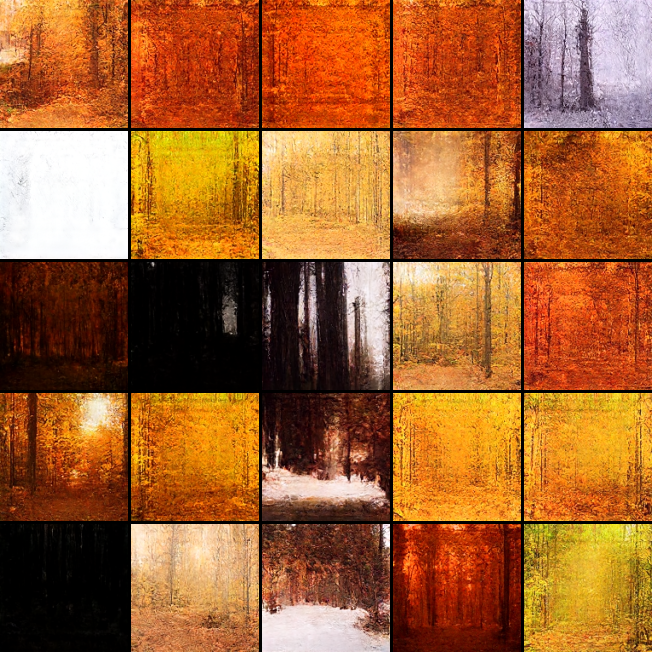

In [41]:
image = Image.fromarray(draw_mulit_images_in_one(y2))
image

In [42]:
image.save("result.png")